In [77]:
import re
import random
import pandas as pd
import hashlib

In [78]:
with open("certcards2.txt", mode="r", encoding="utf8") as f:
    all_cards = f.read()

card_split_pattern = r"\n\n\n\d+\n"
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r"(.+?)\n([\s\S]+)", re.DOTALL)
cards = [
    (match.group(1), match.group(2))
    for cstring in all_cards
    if (match := re.search(card_pattern, cstring))
]

# removing the cards that have no content and trimming
cards = [
    (subject, stripped_content)
    for subject, content in cards
    if len(stripped_content := content.strip()) > 5
]


def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode("utf-8")).hexdigest()


def remake_card_document(
    existing_cards: pd.DataFrame, filename: str = "certcards2.txt"
):
    with open(filename, mode="w", encoding="utf8") as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write("\n" * 6)
            f.write(str(i) + "\n")
            f.write(row["head"] + "\n")
            f.write(row["body"])
            i += 1
    print(f"Cards found: {existing_cards.shape[0]}")
    print(f"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=["head", "body"])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards["hash"] = existing_cards["body"].apply(hash_string_md5)

card_ages = pd.read_json("card_ages.json")
card_ages = card_ages.drop_duplicates(subset=["hash"], keep="first")

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[["hash", "age"]],
    left_on="hash",
    right_on="hash",
    how="left",
)


cards_to_age["head"] = cards_to_age["head"].str.strip()

# remove headers I don't want anymore
undesired_headers = ["CCH Axcess"]
cards_to_age = cards_to_age.loc[~cards_to_age["head"].isin(undesired_headers), :].copy()

cards_to_age["age"] = cards_to_age["age"].fillna(0)

age_factor = 1.01
cards_to_age["age"] = cards_to_age["age"] * age_factor

cards_to_age["age"] = cards_to_age["age"] + [
    random.expovariate(0.5) for _ in cards_to_age.index
]



mean = cards_to_age["age"].mean()
threshold = .005+(mean/2000)
shuffle_role = random.random()
print(f"{shuffle_role=:.6f}; {threshold=:.6f}")
if shuffle_role < threshold:
    cards_to_age["age"] = cards_to_age["age"] * [
        random.expovariate(1.3) for _ in cards_to_age.index
    ]

# Adding priority age growth to cards for upcoming certifications 
priority_headers = [
    "Django", 
    "CCH Tax Forms Project",
    "Microsoft Purview"
    ]
priority_cards_mask = cards_to_age["head"].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, "age"] = (
    cards_to_age.loc[priority_cards_mask, "age"] * 1.0718
)

cards_to_age = cards_to_age.drop_duplicates(subset=["hash"], keep="first")

cards_to_age["subject_mean_age"] = cards_to_age.groupby("head")["age"].transform("mean")
cards_to_age["subject_highest_age"] = cards_to_age.groupby("head")["age"].transform(
    "max"
)
cards_to_age["subject_age_sum"] = cards_to_age.groupby("head")["age"].transform("sum")
cards_to_age["head_random_roll"] = cards_to_age.groupby("head")["head"].transform(
    lambda x: random.random()
)
cards_to_age["head_count"] = cards_to_age.groupby("head")["head"].transform("count")


cards_to_age.sort_values("hash")[["age", "head", "hash"]].to_json(
    "card_ages.json", indent=2
)

existing_cards = cards_to_age

shuffle_role=0.825807; threshold=0.021495


In [79]:
ave_order = ('age', 'mean')
sum_order = ('age', 'sum')

stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(ave_order)
stats.columns = stats.columns.to_flat_index() # type: ignore
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
Ansible,812.897705,10.985104,37.329343,74
"The Simulacra, Dick",12.608402,12.608402,12.608402,1
ODBC,294.104448,18.381528,57.924949,16
Network Terms,292.628395,19.508560,59.413423,15
"Everything is Tuberculosis, Green",489.138086,21.266873,59.805861,23
Exchange Online and Defender,1619.995168,24.545381,190.158560,66
SSH + SCP,815.316578,29.118449,119.410109,28
Terraform Codebox,811.862134,30.068968,101.546605,27
"The Mines of the Behemoth, Shea",1544.200360,31.514293,157.583059,49
Windows PATH Variable,824.309070,32.972363,162.706710,25


# Histogram

sum of ages: ~26583.71


<Axes: >

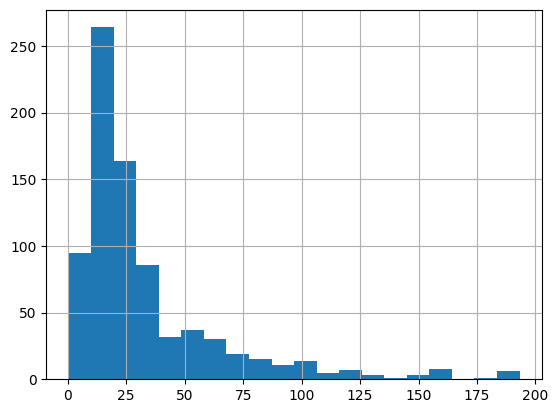

In [80]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~26583.71


<Axes: >

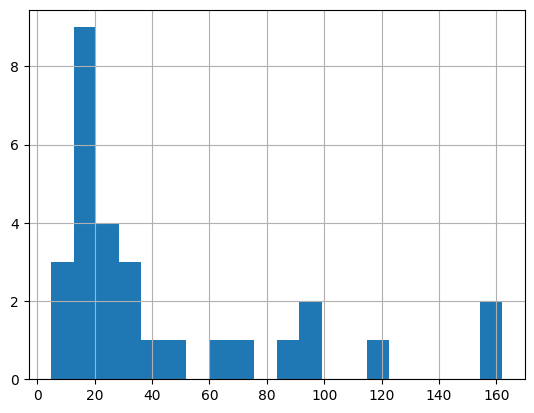

In [81]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='Node.js and Vite']['age'].hist(bins=20)

# Completely Random Shuffle

In [82]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename="certcards2.txt", existing_cards=existing_cards)

# Age Sort

In [83]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# N-fold shuffle


## Age Sum

In [84]:
# n = 3
## m = existing_cards.shape[0]//100
# m = 5
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // m

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [85]:
n=3
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] % n

existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
existing_cards['age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
remake_card_document(existing_cards=existing_cards)

existing_cards.head(10)

Cards found: 801
Total card age: 26583.71


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold
5,Django,Migration\nDjango’s system for version-control...,b91e677ffc19916013b1c1d79e61aeb6,-193.198787,-63.536947,193.198787,889.517255,0.663694,14,0,0
91,Django,Startup Command\nCommand App Service runs to s...,83f4640a04b8cff2171046cc02eb31c4,-73.377968,-63.536947,193.198787,889.517255,0.663694,14,3,0
142,Django,App Service (Azure)\nPaaS hosting option where...,a12ff76278ca13c59010ea67b55f4915,-55.231151,-63.536947,193.198787,889.517255,0.663694,14,6,0
237,Django,Custom Domain Binding\nMapping your Django app...,248b7f02ce05c554f94239ad3a1a3c6a,-33.299377,-63.536947,193.198787,889.517255,0.663694,14,9,0
461,Django,Kudu (Deployment Engine)\nThe deployment backe...,4877a594aa01f8c480087a10c289f6f5,-18.218113,-63.536947,193.198787,889.517255,0.663694,14,12,0
14,Azure Functions Core Tools,Get-Command (PowerShell) – Finds which executa...,0635fb1571b8f8e4280232ceb6070d75,-158.296729,-47.381339,158.296729,805.482769,0.256654,17,0,0
78,Azure Functions Core Tools,MSI vs npm Core Tools – Two distribution metho...,be3d654a7a9a593c77acfc5eab9ca3b3,-70.766757,-47.381339,158.296729,805.482769,0.256654,17,3,0
151,Azure Functions Core Tools,PATH – The OS environment variable listing dir...,f88b1fabd69daf7081a8a0a97ef60df6,-49.207207,-47.381339,158.296729,805.482769,0.256654,17,6,0
231,Azure Functions Core Tools,.NET SDK vs Runtime – SDK includes compilers a...,4837722d5e51b7bde60a1704507d00d3,-32.146457,-47.381339,158.296729,805.482769,0.256654,17,9,0
550,Azure Functions Core Tools,where.exe – Windows-native path resolver; show...,cd96506a72baf6b67479e73a8d9bbf7e,-15.896290,-47.381339,158.296729,805.482769,0.256654,17,12,0


## Age Max

In [86]:
# n = random.choice([2, 3, 3, 4, 4, 5])

# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# # existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [87]:
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()

# choices = ['floor', 'mod']
# option = random.choice(choices)
# if option == 'floor':
#     n=existing_cards.shape[0]//100
#     existing_cards['n_fold'] = existing_cards['count'] // n
#     print("floor dividing for n-fold")
# elif option == 'mod':
#     n=3
#     existing_cards['n_fold'] = existing_cards['count'] % n
#     print("modulo for n-fold")
# else: raise NotImplementedError


# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
#     existing_cards['subject_highest_age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_count', 'subject_highest_age', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [88]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [89]:
existing_cards.head(10)['age'].sum()

np.float64(-699.6388367540937)

In [90]:
asc = existing_cards.age.sum() < 0

existing_cards.sort_values('age', ascending=asc).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold
5,Django,Migration\nDjango’s system for version-control...,b91e677ffc19916013b1c1d79e61aeb6,-193.198787,-63.536947,193.198787,889.517255,0.663694,14,0,0
4,Active Directory and Azure Files,Discretionary ACL (DACL)\nDefines who is allow...,a1bf0647ab4195aec78120763462f822,-192.819237,-46.855292,192.819237,1311.948181,0.807928,28,0,0
0,Python,XML Parsing with ElementTree\nUse xml.etree.El...,5e1ed8426d14aeb2c76d440c1c34ed35,-192.098232,-36.448359,192.098232,1822.417949,0.078997,50,0,0
1,Exchange Online and Defender,You can integrate Defender for Office 365 with...,0f497c29704ee48dd3881866fc98d276,-190.158560,-24.545381,190.158560,1619.995168,0.070140,66,0,0
2,"Mexican Gothic, Moreno-Garcia",portiere (por-TYEHR)\nnoun\nA heavy curtain hu...,d5da010f1b1109c645a0f650a136111b,-186.025248,-39.359703,186.025248,865.913472,0.407435,22,0,0
3,Node.JS and React,State (React)\nA way to store data that change...,583960dd3b7acf10a28fe5f022b65809,-184.805507,-39.260813,184.805507,1217.085200,0.189161,31,0,0
6,Django,Requirements File (requirements.txt)\nLists Py...,013e69aef72c599aa98ad38e306aec0c,-182.202052,-63.536947,193.198787,889.517255,0.663694,14,1,1
7,Windows PATH Variable,Environment Variable Precedence\nOrder of eval...,fa0627e9753a4c1a855bf5f68e7fe4b5,-162.706710,-32.972363,162.706710,824.309070,0.345278,25,0,0
8,Node.js and Vite,Bundling\nThe process of combining many source...,a1c2dae683c349f89a0e85ace26524b9,-162.015505,-44.462440,162.015505,1289.410754,0.191320,29,0,0
10,Azure Files Documentation,"In general, mounting a file share can be simpl...",81a1c65fa9f0cf00782fef00a5373b46,-162.007637,-39.785006,162.007637,1472.045224,0.515294,37,0,0


In [91]:
f"Average age: {abs(existing_cards['age'].mean()):.3f}"

'Average age: 33.188'